# Common
## Imports

In [1]:
from platform import python_version

print(python_version())

3.7.4


In [13]:
import gym

import hiive.mdptoolbox as mdptoolbox
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from IPython.display import clear_output, display

# suppress pandas warning
pd.options.mode.chained_assignment = None

# set seed
np.random.seed(0)

%matplotlib inline

# Helper Functions

In [5]:
colors = {
    b'S': 'b',
    b'F': 'w',
    b'H': 'k',
    b'G': 'g'
}

directions = {
            0: '←',
            1: '↓',
            2: '→',
            3: '↑'
}

def plot_lake(env, policy=None, title='Frozen Lake'):
    squares = env.nrow
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, xlim=(-.01, squares+0.01), ylim=(-.01, squares+0.01))
    plt.title(title, fontsize=16, weight='bold', y=1.01)
    for i in range(squares):
        for j in range(squares):
            y = squares - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[env.desc[i,j]])
            ax.add_patch(p)
            
            if policy is not None:
                text = ax.text(x+0.5, y+0.5, directions[policy[i, j]],
                               horizontalalignment='center', size=25, verticalalignment='center',
                               color='k')
            
    plt.axis('off')
    plt.savefig('./frozen/' + title + '.png', dpi=400)
    
#plot_lake(env, policy)

In [6]:
# code based on:
# https://medium.com/analytics-vidhya/solving-the-frozenlake-environment-from-openai-gym-using-value-iteration-5a078dffe438
def get_score(env, policy, printInfo=False, episodes=1000):
    misses = 0
    steps_list = []
    for episode in range(episodes):
        observation = env.reset()
        steps=0
        while True:
            action = policy[observation]
            observation, reward, done, _ = env.step(action)
            steps+=1
            if done and reward == 1:
                # print('You have got the Frisbee after {} steps'.format(steps))
                steps_list.append(steps)
                break
            elif done and reward == 0:
                # print("You fell in a hole!")
                misses += 1
                break
    ave_steps = np.mean(steps_list)
    std_steps = np.std(steps_list)
    pct_fail  = (misses/episodes)* 100
    
    if (printInfo):
        print('----------------------------------------------')
        print('You took an average of {:.0f} steps to get the frisbee'.format(ave_steps))
        print('And you fell in the hole {:.2f} % of the times'.format(pct_fail))
        print('----------------------------------------------')
  
    return ave_steps, std_steps, pct_fail


In [7]:
# code based on:
# https://medium.com/analytics-vidhya/solving-the-frozenlake-environment-from-openai-gym-using-value-iteration-5a078dffe438
def get_policy(env,stateValue, lmbda=0.9):
    policy = [0 for i in range(env.nS)]
    for state in range(env.nS):
        action_values = []
        for action in range(env.nA):
            action_value = 0
            for i in range(len(env.P[state][action])):
                prob, next_state, r, _ = env.P[state][action][i]
                action_value += prob * (r + lmbda * stateValue[next_state])
            action_values.append(action_value)
        best_action = np.argmax(np.asarray(action_values))
        policy[state] = best_action
    return policy 

# Setup Problem

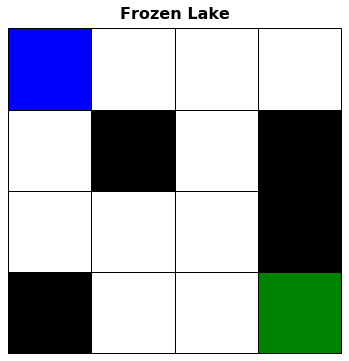

In [8]:
# Setup 4x4
env = gym.make('FrozenLake-v0').unwrapped

env.max_episode_steps=250

# Create transition and reward matrices from OpenAI P matrix
rows = env.nrow
cols = env.ncol
T = np.zeros((4, rows*cols, rows*cols))
R = np.zeros((4, rows*cols, rows*cols))

old_state = np.inf

for square in env.P:
    for action in env.P[square]:
        for i in range(len(env.P[square][action])):
            new_state = env.P[square][action][i][1]
            if new_state == old_state:
                T[action][square][env.P[square][action][i][1]] = T[action][square][old_state] + env.P[square][action][i][0]
                R[action][square][env.P[square][action][i][1]] = R[action][square][old_state] + env.P[square][action][i][2]
            else:
                T[action][square][env.P[square][action][i][1]] = env.P[square][action][i][0]
                R[action][square][env.P[square][action][i][1]] = env.P[square][action][i][2]
            old_state = env.P[square][action][i][1]
            
#print(T)
#print(R)
plot_lake(env)

# Value Iteration
## Function

In [20]:
def valueIteration(t, r, gammas, epsilons, showResults=False, max_iterations=100000):
    t0 = time.time()
    # create data structure to save off
    columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    data = pd.DataFrame(0.0, index=np.arange(len(gammas)*len(epsilons)), columns=columns)
    
    print('Gamma,\tEps,\tTime,\tIter,\tReward')
    print(80*'_')
    
    testNum = 0
    for g in gammas:
        for e in epsilons:
            test = ValueIteration(t, r, gamma=g, epsilon=e, max_iter=max_iterations)
            
            runs  = test.run()
            Time  = runs[-1]['Time']
            iters = runs[-1]['Iteration']
            maxR  = runs[-1]['Max V']
            
            max_rewards, mean_rewards, errors = [], [], []
            for run in runs:
                max_rewards.append(run['Max V'])
                mean_rewards.append(run['Mean V'])
                errors.append(run['Error'])
            
            policy = np.array(test.policy)
            policy = policy.reshape(4,4)
            
            data['gamma'][testNum]        = g
            data['epsilon'][testNum]      = e
            data['time'][testNum]         = Time
            data['iterations'][testNum]   = iters
            data['reward'][testNum]       = maxR
            data['mean_rewards'][testNum] = {tuple(mean_rewards)}
            data['max_rewards'][testNum]  = {tuple(max_rewards)}
            data['error'][testNum]        = {tuple(errors)}
            data['policy'][testNum]       = {test.policy}
            
            print('%.2f,\t%.0E,\t%.2f,\t%d,\t%f' % (g, e, Time, iters, maxR))
            
            if showResults:
                title = 'FrozenLake_VI_' + str(rows) + 'x' + str(cols) + '_g' + str(g) + '_e' + str(e)
                plot_lake(env, policy, title)
            
            testNum = testNum + 1
                
    endTime = time.time() - t0
    print("Time taken: %.2f" %endTime)
    
    # See differences in policy
    policies = data['policy']
    
    for i,p in enumerate(policies):
        pol = list(p)[0]
        steps, steps_stddev, failures = get_score(env, pol, showResults)
        data['average_steps'][i] = steps
        data['steps_stddev'][i]  = steps_stddev
        data['success_pct'][i]   = 100-failures      
        
    # replace all NaN's
    data.fillna(0, inplace=True)
    data.head()
        
    return data

## Setup

In [29]:
gammas   = [0.1, 0.3, 0.6, 0.9]
epsilons = [1e-2, 1e-5, 1e-8, 1e-12]
vi_data  = valueIteration(T, R, gammas, epsilons, showResults=False)

interest = ['gamma', 'epsilon', 'time', 'iterations', 'reward']
df = vi_data[interest]
df.to_csv('frozen/VI_convergence.csv')

#vi_data.head()

Gamma,	Eps,	Time,	Iter,	Reward
________________________________________________________________________________
0.10,	1E-02,	0.00,	1,	0.333333
0.10,	1E-05,	0.00,	4,	0.345235
0.10,	1E-08,	0.00,	7,	0.345239
0.10,	1E-12,	0.00,	11,	0.345239
0.30,	1E-02,	0.00,	3,	0.373333
0.30,	1E-05,	0.00,	8,	0.375101
0.30,	1E-08,	0.00,	13,	0.375103
0.30,	1E-12,	0.00,	20,	0.375103
0.60,	1E-02,	0.00,	6,	0.445120
0.60,	1E-05,	0.00,	17,	0.447647
0.60,	1E-08,	0.00,	29,	0.447649
0.60,	1E-12,	0.00,	46,	0.447649
0.90,	1E-02,	0.00,	26,	0.637540
0.90,	1E-05,	0.01,	77,	0.639019
0.90,	1E-08,	0.01,	128,	0.639020
0.90,	1E-12,	0.01,	195,	0.639020
Time taken: 0.07


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Plots

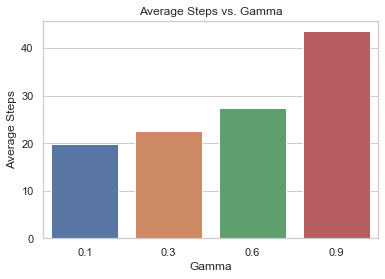

In [23]:
# Compare number of iterations with lowest epsilon

# extract the average number of steps for each gamma value
x = gammas
y = []
for g in gammas:
    y.append(vi_data.loc[vi_data['gamma'] == g]['average_steps'].mean())


sns.set(style="whitegrid")

fig = plt.figure(figsize=(6,4))
ax  = sns.barplot(x, y)
ax.set_title('Average Steps vs. Gamma')
ax.set_xlabel('Gamma')
ax.set_ylabel('Average Steps')

title='VI_averageSteps_vs_gamma'
plt.savefig('./frozen/' + title + '.png', dpi=400)


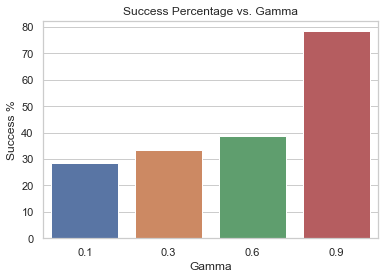

In [24]:
# Compare success of runs

# extract the average success percentage for each gamma value
x = gammas
y = []
for g in gammas:
    y.append(vi_data.loc[vi_data['gamma'] == g]['success_pct'].mean())

fig = plt.figure(figsize=(6,4))
ax  = sns.barplot(x,y)
ax.set_title('Success Percentage vs. Gamma')
ax.set_xlabel('Gamma')
ax.set_ylabel('Success %')

title='VI_successPct_vs_gamma'
plt.savefig('./frozen/' + title + '.png', dpi=400)

## Results

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  after removing the cwd from sys.path.


Best Result:
	Success = 82.50
	Gamma = 0.90
	Epsilon= 1E-12


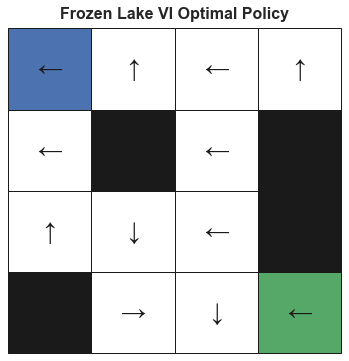

In [25]:
# Plot most successful gamma and epsilon

# find the score with the highest success percentage and get its policy
bestRun = vi_data['success_pct'].argmax()
best_policy = vi_data['policy'][bestRun]
best_policy = np.array(list(best_policy)[0])
best_policy = best_policy.reshape(rows, cols)

# plot the policy
title='Frozen Lake VI Optimal Policy'
plot_lake(env, best_policy, title)

# write all results to csv file
csvFile = 'frozen/VI_results.csv'
vi_data.to_csv(csvFile)

print('Best Result:\n\tSuccess = %.2f\n\tGamma = %.2f\n\tEpsilon= %.E' % (vi_data['success_pct'].max(), vi_data['gamma'][bestRun], vi_data['epsilon'][bestRun]))


# Policy Iteration
## Function

In [35]:
def policyIteration(t, r, gammas, showResults=False, max_iterations=100000):
    t0 = time.time()
    
    # create data structure to save off
    columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    data = pd.DataFrame(0.0, index=np.arange(len(gammas)), columns=columns)
    
    print('gamma,\ttime,\titer,\treward')
    print(80*'_')
    
    testnum = 0
    for g in gammas:
        test = PolicyIteration(t, r, gamma=g, max_iter=max_iterations, eval_type="matrix") # eval_type="iterative"
        
        runs  = test.run()
        Time  = test.time
        iters = test.iter
        maxr  = runs[-1]['Max V']
                
        max_rewards, mean_rewards, errors = [], [], []
        for run in runs:
            max_rewards.append(run['Max V'])
            mean_rewards.append(run['Mean V'])
            errors.append(run['Error'])
        
        policy = np.array(test.policy)
        policy = policy.reshape(4,4)
        
        data['gamma'][testnum]        = g
        data['time'][testnum]         = Time
        data['iterations'][testnum]   = iters
        data['reward'][testnum]       = maxr
        data['mean_rewards'][testnum] = {tuple(mean_rewards)}
        data['max_rewards'][testnum]  = {tuple(max_rewards)}
        data['error'][testnum]        = {tuple(errors)}
        data['policy'][testnum]       = {test.policy}
        
        print('%.2f,\t%.2f,\t%d,\t%f' % (g, Time, iters, maxr))
        
        if showResults:
            title = 'frozenlake_pi_' + str(rows) + 'x' + str(cols) + '_g' + str(g)
            plot_lake(env, policy, title)
        
        testnum = testnum + 1
            
    endTime = time.time() - t0
    print('Time taken: %.2f' % endTime)
    
    # see differences in policy
    policies = data['policy']
    
    for i,p in enumerate(policies):
        pol = list(p)[0]
        steps, steps_stddev, failures = get_score(env, pol, showResults)
        data['average_steps'][i] = steps
        data['steps_stddev'][i]  = steps_stddev
        data['success_pct'][i]   = 100-failures      
        
    # replace all nan's
    data.fillna(0, inplace=True)
    data.head()
        
    return data

## Setup

In [36]:
gammas   = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
pi_data  = policyIteration(T, R, gammas, showResults=False)

#pi_data.head()

gamma,	time,	iter,	reward
________________________________________________________________________________
0.10,	0.00,	4,	0.345239
0.20,	0.00,	4,	0.358992
0.30,	0.00,	4,	0.375103
0.40,	0.00,	4,	0.394332
0.50,	0.00,	4,	0.417861
0.60,	0.00,	4,	0.447649
0.70,	0.00,	4,	0.487267
0.80,	0.00,	5,	0.544196
0.90,	0.00,	5,	0.639020
Time taken: 0.03


## Plots

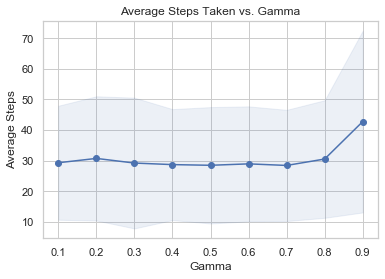

In [37]:
# Compare number of iterations with lowest epsilon

# extract the average number of steps for each gamma value
x = gammas
y = pi_data['average_steps']
sigma = pi_data['steps_stddev']

fig = plt.figure(figsize=(6,4))
plt.plot(x, y, 'o-')
plt.fill_between(x, y-sigma, y+sigma, color='b', alpha=0.1)

plt.title('Average Steps Taken vs. Gamma')
plt.xlabel('Gamma')
plt.ylabel('Average Steps')
plt.grid(True)

title='PI_averageSteps_vs_gamma'
plt.savefig('./frozen/' + title + '.png', dpi=400)

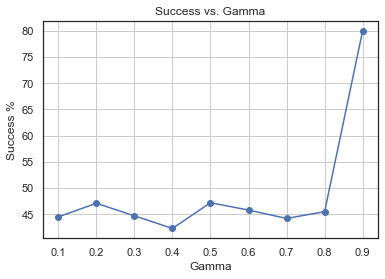

In [49]:
# Compare success of runs

# extract the average success percentage for each gamma value
x = pi_data['gamma']
y = pi_data['success_pct']

fig = plt.figure(figsize=(6,4))
plt.plot(x, y, 'o-')

plt.title('Success vs. Gamma')
plt.xlabel('Gamma')
plt.ylabel('Success %')
plt.grid(True)

title='PI_successPct_vs_gamma'
plt.savefig('./frozen/' + title + '.png', dpi=400)

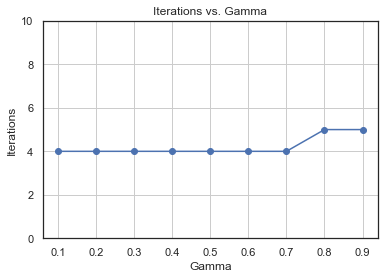

In [48]:
# Compare iterations of runs

# extract the average success percentage for each gamma value
x = pi_data['gamma']
y = pi_data['iterations']

fig = plt.figure(figsize=(6,4))
plt.plot(x, y, 'o-')

plt.title('Iterations vs. Gamma')
plt.xlabel('Gamma')
plt.ylabel('Iterations')
plt.grid(True)
plt.ylim([0, 10])

title='PI_iterations_vs_gamma'
plt.savefig('./frozen/' + title + '.png', dpi=400)

## Results

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  after removing the cwd from sys.path.


Best Result:
	Success = 80.00
	Gamma = 0.90


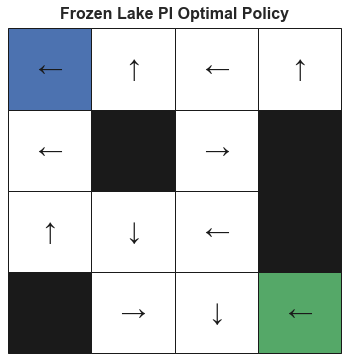

In [39]:
# Plot most successful gamma

# find the score with the highest success percentage and get its policy
bestRun = pi_data['success_pct'].argmax()

best_policy = pi_data['policy'][bestRun]
best_policy = np.array(list(best_policy)[0])
best_policy = best_policy.reshape(rows, cols)

# plot the policy
title='Frozen Lake PI Optimal Policy'
plot_lake(env, best_policy, title)

# write all results to csv file
csvFile = 'frozen/PI_results.csv'
pi_data.to_csv(csvFile)

print('Best Result:\n\tSuccess = %.2f\n\tGamma = %.2f' % (pi_data['success_pct'].max(), pi_data['gamma'][bestRun]))

# Q-Learning

## Function

In [65]:
def qLearning(t, r, gammas, alphas, alpha_decays=[0.99], epsilon_decays=[0.99], n_iterations=[10000000], showResults=False):
    # create data structure to save off
    columns = ['gamma', 'alpha', 'alpha_decay', 'epsilon_decay', 'iterations', 'time', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    numTests = len(gammas)*len(alphas)*len(alpha_decays)*len(epsilon_decays)*len(n_iterations)
    data = pd.DataFrame(0.0, index=np.arange(numTests), columns=columns)
    
    print('Gamma,\tAlpha,\tTime,\tIter,\tReward')
    print(80*'_')
    
    testNum = 0
    for g in gammas:
        for a in alphas:
            for a_decay in alpha_decays:
                for e_decay in epsilon_decays:
                    for n in n_iterations:
                        print('Test Num %d/%d' %(testNum+1, numTests))
                        print('Gamma: %.2f,\tAlpha: %.2f,\tAlpha Decay:%.3f,\tEpsilon Decay:%.3f,\tIterations:%d' 
                             %(g, a, a_decay, e_decay, n))
                        
                        test = QLearning(t, r, gamma=g, alpha=a, alpha_decay=a_decay, epsilon_decay=e_decay, n_iter=n)
                        
                        runs  = test.run()
                        time  = runs[-1]['Time']
                        iters = runs[-1]['Iteration']
                        maxR  = runs[-1]['Max V']
                        
                        max_rewards, mean_rewards, errors = [], [], []
                        for run in runs:
                            max_rewards.append(run['Max V'])
                            mean_rewards.append(run['Mean V'])
                            errors.append(run['Error'])
                        
                        policy = np.array(test.policy)
                        policy = policy.reshape(4,4)
                        
                        data['gamma'][testNum]         = g
                        data['alpha'][testNum]         = a
                        data['alpha_decay'][testNum]   = a_decay
                        data['epsilon_decay'][testNum] = e_decay
                        data['time'][testNum]          = time
                        data['iterations'][testNum]    = iters
                        data['reward'][testNum]        = maxR
                        data['mean_rewards'][testNum]  = {tuple(mean_rewards)}
                        data['max_rewards'][testNum]   = {tuple(max_rewards)}
                        data['error'][testNum]         = {tuple(errors)}
                        data['policy'][testNum]        = {test.policy}
                        
                        print('%.2f,\t%.2f,\t%.2f,\t%d,\t%f' % (g, a, time, iters, maxR))
                        
                        if showResults:
                            title = 'FrozenLake_QL_' + str(rows) + 'x' + str(cols) + '_g' + str(g) + '_a' + str(a) + '_adecay' + str(a_decay) + '_edecay' + str(e_decay) + '_iter' + str(n)
                            plot_lake(env, policy, title)
                        
                        testNum = testNum + 1
            
    # See differences in policy
    policies = data['policy']
    
    for i,p in enumerate(policies):
        pol = list(p)[0]
        steps, steps_stddev, failures = get_score(env, pol, showResults)
        data['average_steps'][i] = steps
        data['steps_stddev'][i]  = steps_stddev
        data['success_pct'][i]   = 100-failures      
        
    # replace all NaN's
    data.fillna(0, inplace=True)
    data.head()
        
    return data

## Setup

In [50]:
gammas   = [0.8, 0.9, 0.99]
alphas   = [0.01, 0.1, 0.2]
alpha_decays = [0.9, 0.999]
epsilon_decays = [0.9, 0.999]
iterations = [1e5, 1e6, 1e7]

''' PROCEED WITH CAUTION >>>> THIS WILL OVERWRITE DATA AND TAKE HOURS

ql_data  = qLearning(T, R, gammas, alphas, alpha_decays=alpha_decays, epsilon_decays=epsilon_decays, n_iterations=iterations, showResults=True)

# write all results to csv file
csvFile = 'frozen/QL_results.csv'
ql_data.to_csv(csvFile)

'''

#ql_data.head()



" PROCEED WITH CAUTION >>>> THIS WILL OVERWRITE DATA AND TAKE HOURS\n\nql_data  = qLearning(T, R, gammas, alphas, alpha_decays=alpha_decays, epsilon_decays=epsilon_decays, n_iterations=iterations, showResults=True)\n\n# write all results to csv file\ncsvFile = 'frozen/QL_results.csv'\nql_data.to_csv(csvFile)\n\n"

In [42]:
# Read in Q-Learning data
ql_data = pd.read_csv('frozen/QL_results.csv')
ql_data.head()

,Unnamed: 0,Unnamed: 0.1,gamma,alpha,alpha_decay,epsilon_decay,iterations,time,reward,average_steps,steps_stddev,success_pct,policy,mean_rewards,max_rewards,error
0,0,0,0.8,0.01,0.9,0.900,100000.0,4.840734,0.087957,12.463415,5.605300,4.1,"{(2, 1, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 1, 2,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,1,0.8,0.01,0.9,0.900,1000000.0,46.825693,0.472730,12.836735,5.640042,4.9,"{(1, 2, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0, 0, 2, 1,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2,2,0.8,0.01,0.9,0.900,10000000.0,480.157838,0.551939,17.693642,8.749818,17.3,"{(1, 3, 2, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 1,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,3,3,0.8,0.01,0.9,0.999,100000.0,4.869994,0.101924,27.400000,21.265935,17.0,"{(2, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 3,...","{(0.000625, 0.000625, 0.000625, 0.000625, 0.00...","{(0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0....","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,4,4,0.8,0.01,0.9,0.999,1000000.0,47.322821,0.461346,24.945055,14.988906,9.1,"{(0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 1,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [43]:
# Look at correlation matrix
interest = ['gamma', 'alpha', 'alpha_decay', 'epsilon_decay', 'iterations', 'reward', 'time', 'success_pct']

# pick out hyperparameters and how succesful they were
df = ql_data[interest]

# See what affected the success_pct the most
ql_corr = df.corr()

## Plots

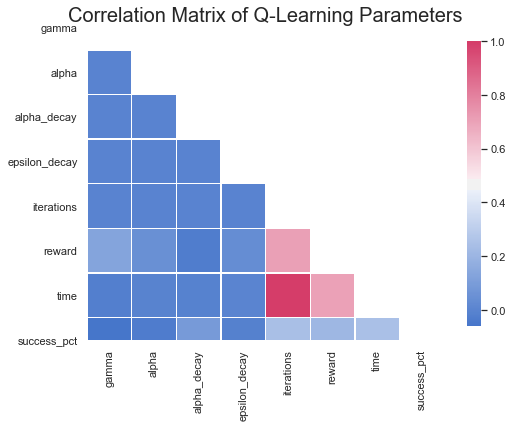

In [44]:
# Create heatmap of correlation matrix
sns.set(style="white")
fig, ax = plt.subplots(figsize=(8,7))
ax.set_title('Correlation Matrix of Q-Learning Parameters', fontsize=20)
mask = np.triu(np.ones_like(ql_corr, dtype=np.bool))
cmap = sns.diverging_palette(255, 0, as_cmap=True)
sns.heatmap(ql_corr, mask=mask, cmap=cmap, square=True, linewidths=0.5, cbar_kws={"shrink":.75})

In [45]:
def plot_QL(dependent, independent, title=None, logscale=False):
    if dependent not in interest:
        print('Dependent variable not available')
        return
    if independent not in interest:
        print('Independent variable not available')
        return
    
    x = np.unique(df[dependent])
    y = []
    
    for i in x:
        y.append(df.loc[df[dependent] == i][independent].mean())
        
    fig = plt.figure(figsize=(6,4))
    plt.plot(x, y, 'o-')
    
    if title == None:
        title = independent + ' vs. ' + dependent
    plt.title(title, fontsize=15)
    plt.xlabel(dependent)
    plt.ylabel(independent)
    plt.grid(True)
    if logscale:
        plt.xscale('log')
    
    title='QL_' + independent + '_vs_' + dependent
    plt.savefig('./frozen/' + title + '.png', dpi=400)
    

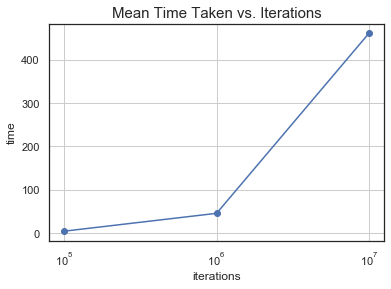

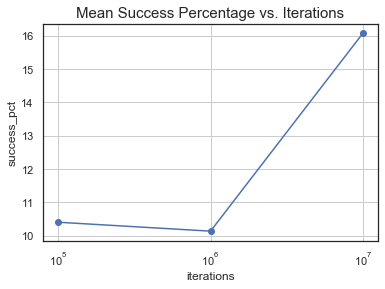

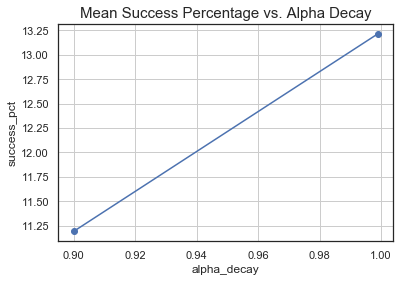

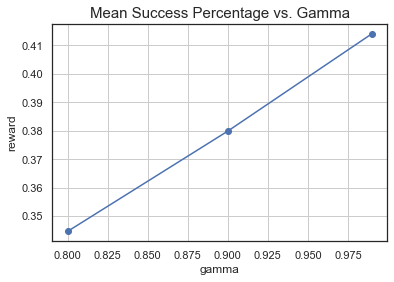

In [46]:
# Plot values vs. Iterations
plot_QL('iterations', 'time', title='Mean Time Taken vs. Iterations', logscale=True)
plot_QL('iterations', 'success_pct', title='Mean Success Percentage vs. Iterations', logscale=True)

# Plot alpha decay vs success pct
plot_QL('alpha_decay', 'success_pct', title='Mean Success Percentage vs. Alpha Decay')

# Plot results vs. gamma
plot_QL('gamma', 'reward', title='Mean Success Percentage vs. Gamma')

## Results

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  after removing the cwd from sys.path.


Best Result:
	Success = 66.10
	Gamma = 0.99,
	Alpha = 0.01,
	Alpha Decay: 0.999,
	Epsilon Decay: 0.999,
	Iterations: 1.0E+07


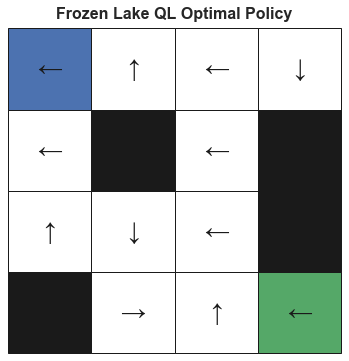

In [47]:
# Plot most successful gamma

# find the score with the highest success percentage and get its policy
bestRun = ql_data['success_pct'].argmax()

best_policy = ql_data['policy'][bestRun]

# reshape the policy since we pulled from a csv file
best_policy = best_policy[1:-1]
best_policy = eval(best_policy)
best_policy = np.array(best_policy)
best_policy = best_policy.reshape(rows, cols)

# plot the policy
title='Frozen Lake QL Optimal Policy'
plot_lake(env, best_policy, title)

print('Best Result:\n\tSuccess = %.2f\n\tGamma = %.2f,\n\tAlpha = %.2f,\n\tAlpha Decay: %.3f,\n\tEpsilon Decay: %.3f,\n\tIterations: %.1E' 
      % (ql_data['success_pct'].max(), ql_data['gamma'][bestRun], ql_data['alpha'][bestRun], ql_data['alpha_decay'][bestRun], ql_data['epsilon_decay'][bestRun], ql_data['iterations'][bestRun]))